In [1]:
import random
import math
import datetime
import numpy as np
import matplotlib.pyplot as plt
import instance_maker as ins
import algorithms as algo

#repeat the experiment and take the average cost
#change it to 100 if you want to reproduce the result, though it will be slow. 
experiment_num = 2

#fixed parameters
time_length = 2000
interval_mean = 2
shape = 2
price_mean = 100

#enumerating parameters
price_dists = ["Uniform", "Normal", "Pareto"]
Lambdas = [1, 0.5, 0.2]
perturb_probabilitys = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
algorithms = ["SUM", "FSUM", r'SUM$_w$', "PFSUM"]
for Lambda in Lambdas:
    algorithms.append("PDLA({}={})".format(r'$\lambda$', Lambda))

for Lambda in Lambdas:
    algorithms.append("SRL({}={})".format(r'$\lambda$', Lambda))

#competitive ratios
result_crs = []


In [2]:
#evaluate algorithms
def evaluate(instance, noisy_instance, parameter_sets, price_dist, perturb_prob):
    for param in parameter_sets:
        beta = param[0]
        T = param[1]
        C = param[2]
        w = int(T / 2)
        
        offline_cost, offline_solution = algo.OFFLINE_OPTIMAL(instance, T, C, beta)

        noisy_offline_cost, noisy_offline_solution = algo.OFFLINE_OPTIMAL(noisy_instance, T, C, beta)
        noisy_prediction = ins.prediction_generator(noisy_instance, T)
        noisy_w_prediction = ins.prediction_generator(noisy_instance, w)

        sum_cost, sum_solution = algo.SUM(instance, T, C, beta)
        fsum_cost, fsum_solution = algo.FSUM(instance, T, C, beta, noisy_prediction)
        sum_w_cost, sum_w_solution = algo.SUM_W(instance, T, C, beta, noisy_w_prediction)
        pfsum_cost, pfsum_solution = algo.PFSUM(instance, T, C, beta, noisy_prediction)

        result_crs.append(("SUM", beta, T, perturb_prob, price_dist, C, sum_cost / offline_cost))
        result_crs.append(("FSUM", beta, T, perturb_prob, price_dist, C, fsum_cost / offline_cost))
        result_crs.append((r'SUM$_w$', beta, T, perturb_prob, price_dist, C, sum_w_cost / offline_cost))
        result_crs.append(("PFSUM", beta, T, perturb_prob, price_dist, C, pfsum_cost / offline_cost))

        for Lambda in Lambdas:
            pdla_cost, pdla_solution = algo.PDLA_FOR_BAHNCARD(instance, T, C, beta, Lambda, noisy_offline_solution)
            result_crs.append(("PDLA({}={})".format(r'$\lambda$', Lambda), beta, T, perturb_prob, price_dist, C, pdla_cost / offline_cost))
            
            srl_cost, srl_solution = algo.SRL(instance, T, C, beta, noisy_prediction, noisy_instance, Lambda)
            result_crs.append(("SRL({}={})".format(r'$\lambda$', Lambda), beta, T, perturb_prob, price_dist, C, srl_cost / offline_cost))

#plot results
def plot_cr(beta, T, C, price_dist, profile):
    points = {}
    for algo in algorithms:
        points[algo] = {}
        for perturb_prob in perturb_probabilitys:
            points[algo][perturb_prob] = [0, 0, []]

    #r[0: algorithm; 1: beta; 2: T; 3: perturb_prob; 4: price_dict; 5: C; 6: CR]
    #points[algorithm][perturb_prob][0: sum of CR; 1: number; 2: list of CR]
    for r in result_crs:
        if (r[1] != beta or r[2] != T or r[4] != price_dist or r[5] != C): continue
        points[r[0]][r[3]][0] += r[6]
        points[r[0]][r[3]][1] += 1
        points[r[0]][r[3]][2].append(r[6])

    for algo in algorithms:
        bestn = 0
        num = len(points[algo][0][2])
        for i in range(0, num):
            best_one = 1
            for a2 in algorithms:
                if points[algo][0][2][i] > points[a2][0][2][i]:
                    best_one = 0
                    break
            if best_one == 1:
                bestn += 1
        print("best " + algo + ": ", bestn)
    
    ls = ['-', '-', '-', '-', ':', ':', ':', '-', '-', '-']
    marker = ['', '^', 's', 'o', '', '^', 'o', '', '^', 'o']
    plot_list = []

    fi = plt.figure(figsize=(6, 4.5))
    fi.set_rasterized(True)
    f = fi.add_subplot()
    f.set_rasterized(True)
    
    idx = 0
    for algo in algorithms:
        l = []
        l_ci_upper = []
        l_ci_lower = []
        for perturb_prob in perturb_probabilitys:
            mean = points[algo][perturb_prob][0] / points[algo][perturb_prob][1]
            l.append(round(mean, 4))
            points[algo][perturb_prob][2].sort()
            num = len(points[algo][perturb_prob][2])
            #95% confidence intervals
            l_ci_upper.append(points[algo][perturb_prob][2][int(num * 0.975)])
            l_ci_lower.append(points[algo][perturb_prob][2][int(num * 0.025)])

        if (algo == "PFSUM"):
            f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'red', alpha=0.2)
            p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='red', label=algo)
            plot_list.append(p)
            print(algo + " " + str(l))

        elif (algo == "FSUM"):
            f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'green', alpha=0.1)  
            p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='green', label=algo)
            plot_list.append(p)
            print(algo + " " + str(l))

        elif (algo[:4] == "PDLA"):
            #f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'gray', alpha=0.1) 
            #p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='gray', label=algo)
            #plot_list.append(p)
            print(algo + " " + str(l))

        elif (algo[:3] == "SRL"):
            #f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'purple', alpha=0.1) 
            #p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='purple', label=algo)
            #plot_list.append(p)
            print(algo + " " + str(l))
            
        elif (algo == r'SUM$_w$'):
            #f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'blue', alpha=0.1) 
            #p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='blue', label=algo)
            #plot_list.append(p)
            print(algo + " " + str(l))
            
        else:
            f.fill_between(perturb_probabilitys, l_ci_lower, l_ci_upper, color = 'black', alpha=0.1) 
            p, = f.plot(perturb_probabilitys, l, ls=ls[idx], marker=marker[idx], linewidth=1, ms=6, color='black', label=algo)
            plot_list.append(p)
            print(algo + " " + str(l))
        
        idx += 1

    print("{}, Beta = {}, T = {}, C = {}, Price distribution = {}".format(profile, beta, T, C, price_dist))
    plt.xlabel("Perturbing probability", fontsize=22)
    plt.ylabel("Average cost ratio", fontsize=22)
    f.tick_params(labelsize=17)

    legend = 1
    fname = "./figs/{}_{}_beta_{}_T_{}_C_{}_L{}_results.pdf".format(profile, price_dist, beta, T, C, legend)

    if legend == 1:
        first_legend = f.legend(handles = plot_list, loc = 'upper left', ncol = 1, bbox_to_anchor = (1, 1), prop = {'size': 15}, framealpha=0.5)
        #plt.gca().add_artist(first_legend)
    #f.legend(handles = plot_list[0:5], loc = 'center right', bbox_to_anchor = (1, legend_anchor[1]), prop = {'size': 13}, framealpha=0.5)
    #plt.gcf().subplots_adjust(left = 0.14, bottom = 0.14)
    if legend == 1:
        fi.savefig(fname, bbox_inches = 'tight', bbox_extra_artists=(first_legend,), format='pdf')
    else:
        fi.savefig(fname, bbox_inches = 'tight', format='pdf')
    plt.show()



In [3]:
#clear results
result_crs = []

#for the occasional travelers, travel requests occur at intervals
parameter_sets = [(0.8, 10, 100), (0.6, 5, 100), (0.6, 10, 200), (0.6, 10, 2000), (0.2, 10, 400)]

for price_dist in price_dists:
    for exp_count in range(0, experiment_num):
        #generate an instance
        #np.random.seed(int(datetime.datetime.now().timestamp()))
        np.random.seed(exp_count)
        instance = ins.instance_generator(time_length, "Uniform", interval_mean, price_dist, price_mean)
        for perturb_prob in perturb_probabilitys:
            noisy_instance = ins.noisy_instance_generator(instance, price_dist, 2 * price_mean, perturb_prob)
            evaluate(instance, noisy_instance, parameter_sets, price_dist, perturb_prob)


bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by 

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  2
SUM [1.0334, 1.0334, 1.0334, 1.0334, 1.0334, 1.0334, 1.0334, 1.0334, 1.0334, 1.0334, 1.0334]
FSUM [1.0089, 1.0089, 1.0089, 1.0089, 1.0089, 1.0089, 1.0089, 1.0089, 1.0089, 1.0089, 1.0089]
SUM$_w$ [1.0086, 1.0075, 1.0067, 1.0053, 1.0043, 1.0044, 1.0041, 1.0041, 1.0039, 1.0039, 1.0039]
PFSUM [1.0042, 1.0042, 1.0043, 1.0043, 1.0043, 1.0043, 1.0043, 1.0043, 1.0044, 1.0043, 1.0043]
PDLA($\lambda$=1) [1.0862, 1.0862, 1.0862, 1.0862, 1.0862, 1.0862, 1.0862, 1.0862, 1.0862, 1.0862, 1.0862]
PDLA($\lambda$=0.5) [1.06, 1.0601, 1.0603, 1.0606, 1.0601, 1.0602, 1.0604, 1.0616, 1.0612, 1.061, 1.061]
PDLA($\lambda$=0.2) [1.0325, 1.0336, 1.0342, 1.0343, 1.0352, 1.0342, 1.0353, 1.0349, 1.0351, 1.035, 1.0351]
SRL($\lambda$=1) [1.0044, 1.0044, 1.0044, 1.0044, 1.0044, 1.0044, 1.0044, 1

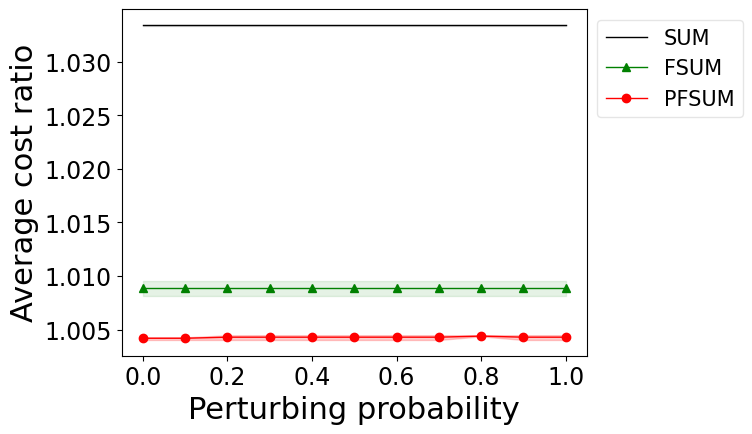

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  2
SUM [1.034, 1.034, 1.034, 1.034, 1.034, 1.034, 1.034, 1.034, 1.034, 1.034, 1.034]
FSUM [1.0055, 1.0055, 1.0055, 1.0055, 1.0055, 1.0055, 1.0055, 1.0055, 1.0055, 1.0055, 1.0055]
SUM$_w$ [1.0068, 1.005, 1.0048, 1.004, 1.0027, 1.0027, 1.0023, 1.0024, 1.0022, 1.0021, 1.0021]
PFSUM [1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026]
PDLA($\lambda$=1) [1.0874, 1.0874, 1.0874, 1.0874, 1.0874, 1.0874, 1.0874, 1.0874, 1.0874, 1.0874, 1.0874]
PDLA($\lambda$=0.5) [1.0595, 1.0596, 1.0594, 1.0594, 1.0594, 1.0588, 1.0591, 1.0593, 1.0589, 1.0591, 1.0591]
PDLA($\lambda$=0.2) [1.0327, 1.0329, 1.033, 1.0328, 1.0333, 1.033, 1.0332, 1.0329, 1.0329, 1.033, 1.0327]
SRL($\lambda$=1) [1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.0026, 1.00

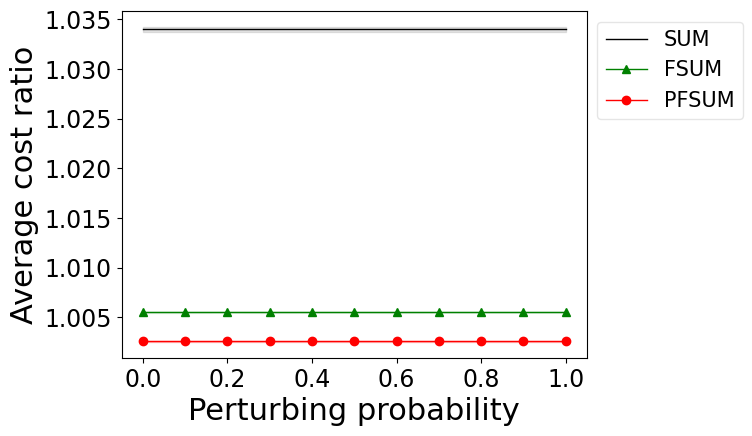

best SUM:  0
best FSUM:  0
best SUM$_w$:  1
best PFSUM:  1
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.022, 1.022, 1.022, 1.022, 1.022, 1.022, 1.022, 1.022, 1.022, 1.022, 1.022]
FSUM [1.0221, 1.0225, 1.0231, 1.0233, 1.0236, 1.0233, 1.0236, 1.0235, 1.0236, 1.0236, 1.0238]
SUM$_w$ [1.0119, 1.0123, 1.0124, 1.0126, 1.012, 1.0134, 1.0137, 1.0131, 1.0132, 1.014, 1.0141]
PFSUM [1.0115, 1.0125, 1.0136, 1.0134, 1.0137, 1.0137, 1.014, 1.014, 1.014, 1.0141, 1.0141]
PDLA($\lambda$=1) [1.1014, 1.1014, 1.1014, 1.1014, 1.1014, 1.1014, 1.1014, 1.1014, 1.1014, 1.1014, 1.1014]
PDLA($\lambda$=0.5) [1.0701, 1.0716, 1.074, 1.0755, 1.0742, 1.0755, 1.0741, 1.0775, 1.0763, 1.0751, 1.0758]
PDLA($\lambda$=0.2) [1.0438, 1.0441, 1.0474, 1.0496, 1.0505, 1.0508, 1.0534, 1.0518, 1.0526, 1.0525, 1.0518]
SRL($\lambda$=1) [1.0142, 1.0142, 1.0142, 1.0142, 1.0142, 1.0142, 1.0142, 1.0142, 1.014

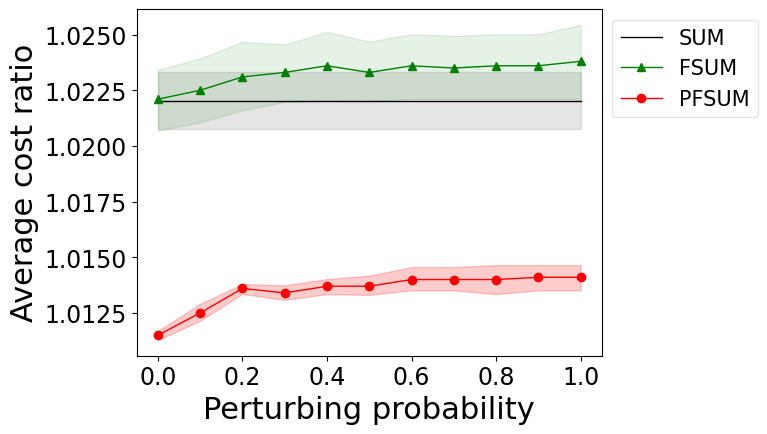

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  2
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.066, 1.066, 1.066, 1.066, 1.066, 1.066, 1.066, 1.066, 1.066, 1.066, 1.066]
FSUM [1.0354, 1.0358, 1.0364, 1.0364, 1.0366, 1.0368, 1.0369, 1.037, 1.037, 1.037, 1.037]
SUM$_w$ [1.0356, 1.0333, 1.0294, 1.0284, 1.0266, 1.0245, 1.0226, 1.0206, 1.0196, 1.0167, 1.015]
PFSUM [1.0128, 1.0133, 1.0134, 1.0135, 1.0139, 1.0135, 1.0137, 1.0137, 1.0137, 1.0137, 1.0137]
PDLA($\lambda$=1) [1.2281, 1.2281, 1.2281, 1.2281, 1.2281, 1.2281, 1.2281, 1.2281, 1.2281, 1.2281, 1.2281]
PDLA($\lambda$=0.5) [1.1617, 1.1635, 1.1642, 1.1631, 1.1644, 1.164, 1.1661, 1.1651, 1.165, 1.1665, 1.1663]
PDLA($\lambda$=0.2) [1.1148, 1.1171, 1.1216, 1.1201, 1.1248, 1.1252, 1.1259, 1.1255, 1.1278, 1.1271, 1.1269]
SRL($\lambda$=1) [1.0139, 1.0139, 1.0139, 1.0139, 1.0139, 1.0139, 1.0139, 1.0139, 1.0139

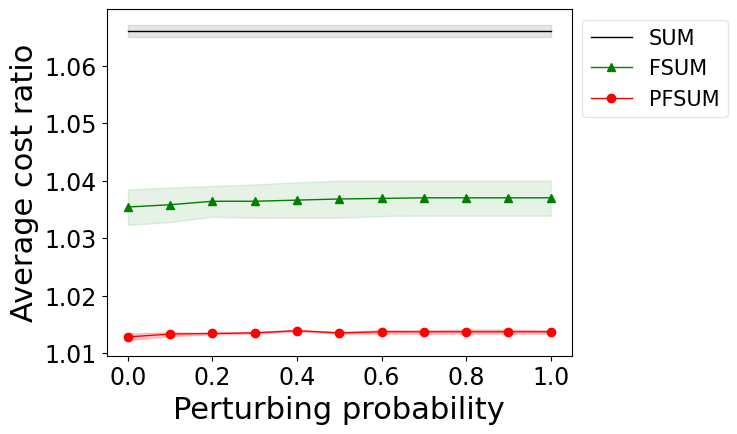

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  2
SUM [1.0674, 1.0674, 1.0674, 1.0674, 1.0674, 1.0674, 1.0674, 1.0674, 1.0674, 1.0674, 1.0674]
FSUM [1.0261, 1.0261, 1.0263, 1.0261, 1.0263, 1.0261, 1.0263, 1.0263, 1.0263, 1.0263, 1.0263]
SUM$_w$ [1.0341, 1.0322, 1.0285, 1.0262, 1.0263, 1.0219, 1.0209, 1.0188, 1.015, 1.0112, 1.0096]
PFSUM [1.0081, 1.0082, 1.0082, 1.0086, 1.0086, 1.0085, 1.0086, 1.0086, 1.0086, 1.0086, 1.0086]
PDLA($\lambda$=1) [1.2289, 1.2289, 1.2289, 1.2289, 1.2289, 1.2289, 1.2289, 1.2289, 1.2289, 1.2289, 1.2289]
PDLA($\lambda$=0.5) [1.1614, 1.1612, 1.1619, 1.1613, 1.1605, 1.1619, 1.1623, 1.1625, 1.1617, 1.1616, 1.1617]
PDLA($\lambda$=0.2) [1.1113, 1.1131, 1.1139, 1.1154, 1.1167, 1.1158, 1.1175, 1.1174, 1.1175, 1.1181, 1.1175]
SRL($\lambda$=1) [1.0086, 1.0086, 1.0086, 1.0086, 1.0086, 1.0086, 1.008

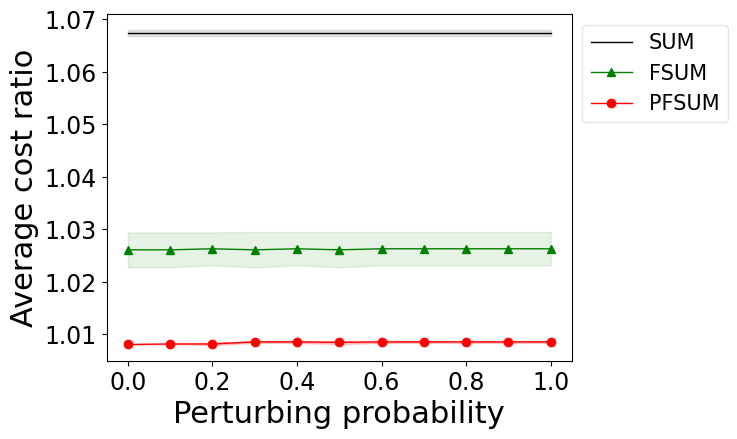

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  2
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0368, 1.0368, 1.0368, 1.0368, 1.0368, 1.0368, 1.0368, 1.0368, 1.0368, 1.0368, 1.0368]
FSUM [1.0461, 1.0471, 1.049, 1.0488, 1.0496, 1.0513, 1.0515, 1.0521, 1.0524, 1.0525, 1.0525]
SUM$_w$ [1.031, 1.032, 1.0358, 1.0355, 1.0356, 1.0381, 1.0354, 1.0362, 1.0395, 1.038, 1.0371]
PFSUM [1.024, 1.0254, 1.0289, 1.0297, 1.0319, 1.0338, 1.0337, 1.0359, 1.0354, 1.0355, 1.036]
PDLA($\lambda$=1) [1.2563, 1.2563, 1.2563, 1.2563, 1.2563, 1.2563, 1.2563, 1.2563, 1.2563, 1.2563, 1.2563]
PDLA($\lambda$=0.5) [1.2175, 1.2248, 1.2367, 1.2263, 1.2351, 1.2249, 1.2343, 1.2306, 1.2298, 1.2298, 1.231]
PDLA($\lambda$=0.2) [1.1448, 1.1472, 1.1595, 1.1676, 1.1762, 1.1677, 1.176, 1.1865, 1.1875, 1.1911, 1.1953]
SRL($\lambda$=1) [1.036, 1.036, 1.036, 1.036, 1.036, 1.036, 1.036, 1.036, 1.03

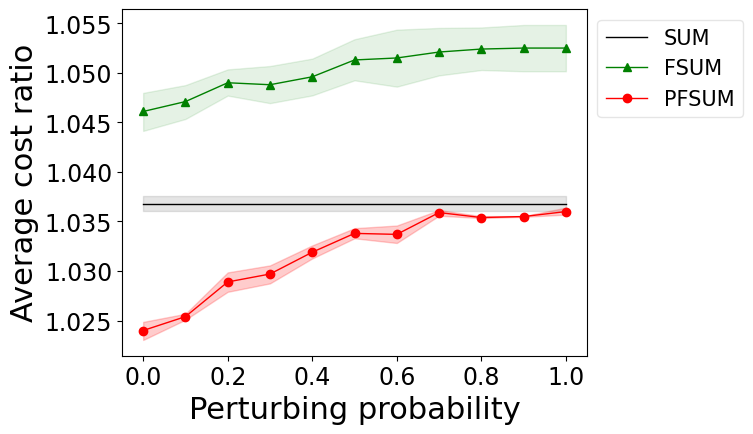

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  2
SUM [1.0757, 1.0757, 1.0757, 1.0757, 1.0757, 1.0757, 1.0757, 1.0757, 1.0757, 1.0757, 1.0757]
FSUM [1.0238, 1.0238, 1.024, 1.0241, 1.0241, 1.0241, 1.0241, 1.0241, 1.0241, 1.0241, 1.0241]
SUM$_w$ [1.0195, 1.016, 1.0153, 1.0119, 1.0098, 1.01, 1.0092, 1.0092, 1.0088, 1.0088, 1.0087]
PFSUM [1.0094, 1.0094, 1.0096, 1.0097, 1.0097, 1.0097, 1.0097, 1.0097, 1.01, 1.0097, 1.0097]
PDLA($\lambda$=1) [1.1952, 1.1952, 1.1952, 1.1952, 1.1952, 1.1952, 1.1952, 1.1952, 1.1952, 1.1952, 1.1952]
PDLA($\lambda$=0.5) [1.1359, 1.1362, 1.1366, 1.1372, 1.1362, 1.137, 1.1369, 1.1395, 1.1386, 1.1381, 1.1381]
PDLA($\lambda$=0.2) [1.0735, 1.0761, 1.0775, 1.0778, 1.0798, 1.0775, 1.0799, 1.079, 1.0795, 1.0793, 1.0796]
SRL($\lambda$=1) [1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 

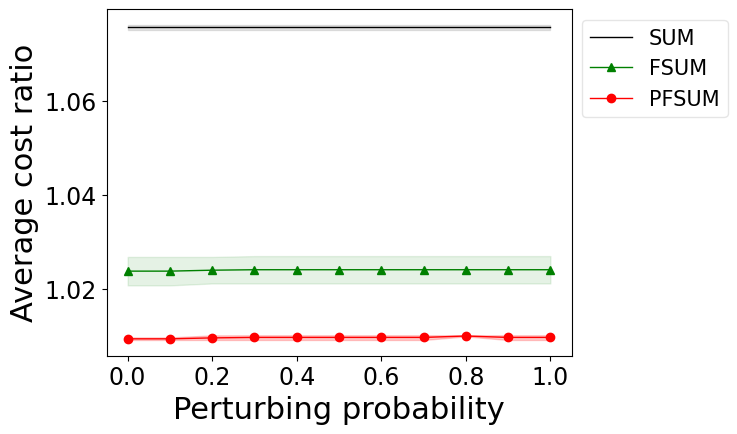

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  2
SUM [1.0761, 1.0761, 1.0761, 1.0761, 1.0761, 1.0761, 1.0761, 1.0761, 1.0761, 1.0761, 1.0761]
FSUM [1.0156, 1.0156, 1.0156, 1.0156, 1.0159, 1.0156, 1.0156, 1.0156, 1.0159, 1.0156, 1.0159]
SUM$_w$ [1.0151, 1.0111, 1.0109, 1.0088, 1.0062, 1.006, 1.0052, 1.0055, 1.005, 1.0047, 1.0047]
PFSUM [1.0058, 1.0058, 1.0058, 1.0058, 1.0058, 1.0058, 1.0058, 1.0058, 1.0058, 1.0058, 1.0058]
PDLA($\lambda$=1) [1.1974, 1.1974, 1.1974, 1.1974, 1.1974, 1.1974, 1.1974, 1.1974, 1.1974, 1.1974, 1.1974]
PDLA($\lambda$=0.5) [1.1344, 1.1346, 1.1342, 1.1341, 1.1342, 1.1329, 1.1334, 1.1339, 1.1331, 1.1334, 1.1334]
PDLA($\lambda$=0.2) [1.0739, 1.0744, 1.0746, 1.0741, 1.0752, 1.0746, 1.0749, 1.0743, 1.0743, 1.0744, 1.0739]
SRL($\lambda$=1) [1.0058, 1.0058, 1.0058, 1.0058, 1.0058, 1.0058, 1.0058

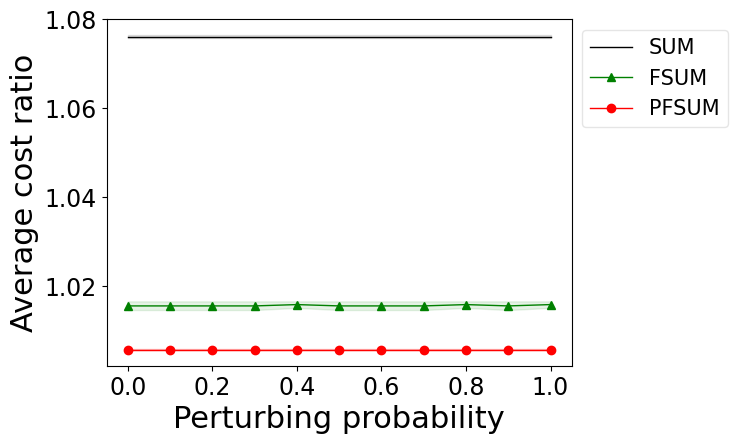

best SUM:  0
best FSUM:  0
best SUM$_w$:  1
best PFSUM:  1
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0506, 1.0506, 1.0506, 1.0506, 1.0506, 1.0506, 1.0506, 1.0506, 1.0506, 1.0506, 1.0506]
FSUM [1.055, 1.056, 1.0572, 1.0581, 1.0577, 1.0581, 1.0586, 1.0586, 1.0586, 1.0586, 1.0586]
SUM$_w$ [1.0265, 1.0281, 1.0279, 1.0292, 1.0274, 1.0311, 1.0314, 1.03, 1.0304, 1.032, 1.0323]
PFSUM [1.0265, 1.0288, 1.0312, 1.0308, 1.0314, 1.0316, 1.0322, 1.0322, 1.0322, 1.0323, 1.0323]
PDLA($\lambda$=1) [1.2328, 1.2328, 1.2328, 1.2328, 1.2328, 1.2328, 1.2328, 1.2328, 1.2328, 1.2328, 1.2328]
PDLA($\lambda$=0.5) [1.1609, 1.1644, 1.1698, 1.1735, 1.1702, 1.1733, 1.1702, 1.1779, 1.1753, 1.1724, 1.1741]
PDLA($\lambda$=0.2) [1.1006, 1.1012, 1.1087, 1.114, 1.116, 1.1167, 1.1226, 1.1188, 1.1208, 1.1206, 1.1189]
SRL($\lambda$=1) [1.0326, 1.0326, 1.0326, 1.0326, 1.0326, 1.0326, 1.0326, 1.0

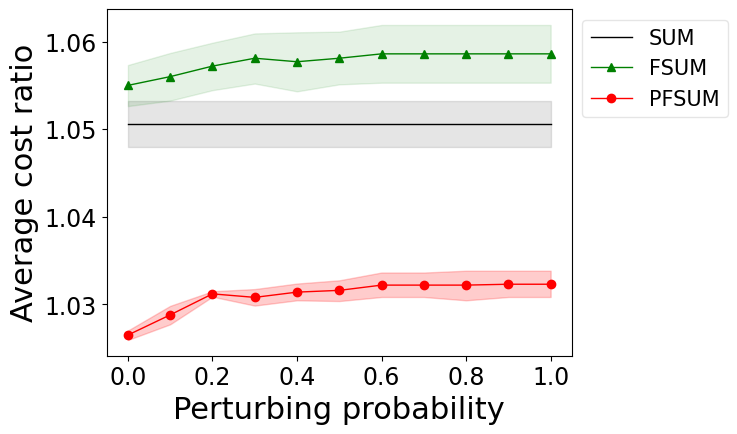

best SUM:  2
best FSUM:  2
best SUM$_w$:  2
best PFSUM:  2
best PDLA($\lambda$=1):  2
best PDLA($\lambda$=0.5):  2
best PDLA($\lambda$=0.2):  2
best SRL($\lambda$=1):  2
best SRL($\lambda$=0.5):  2
best SRL($\lambda$=0.2):  2
SUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
FSUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SUM$_w$ [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PFSUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=1) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=0.5) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=0.2) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=1) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=0.5) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=0.2) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Commuters, Beta = 0.6, T = 10, C = 2000, Price distribution = Uniform


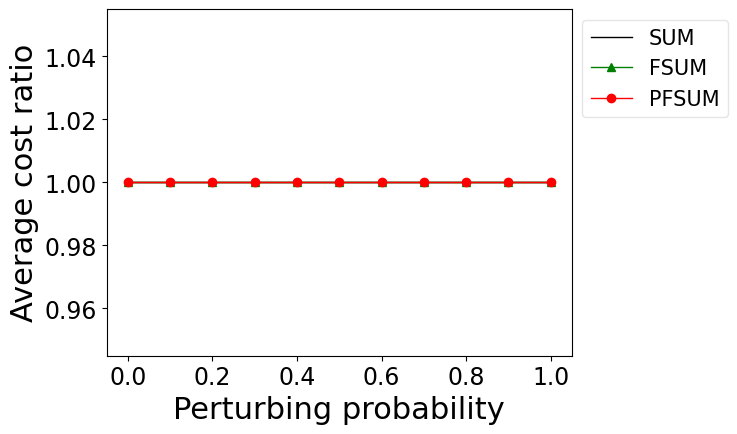

best SUM:  2
best FSUM:  2
best SUM$_w$:  2
best PFSUM:  2
best PDLA($\lambda$=1):  2
best PDLA($\lambda$=0.5):  2
best PDLA($\lambda$=0.2):  2
best SRL($\lambda$=1):  2
best SRL($\lambda$=0.5):  2
best SRL($\lambda$=0.2):  2
SUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
FSUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SUM$_w$ [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PFSUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=1) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=0.5) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=0.2) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=1) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=0.5) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=0.2) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Commuters, Beta = 0.6, T = 10, C = 2000, Price distribution = Normal


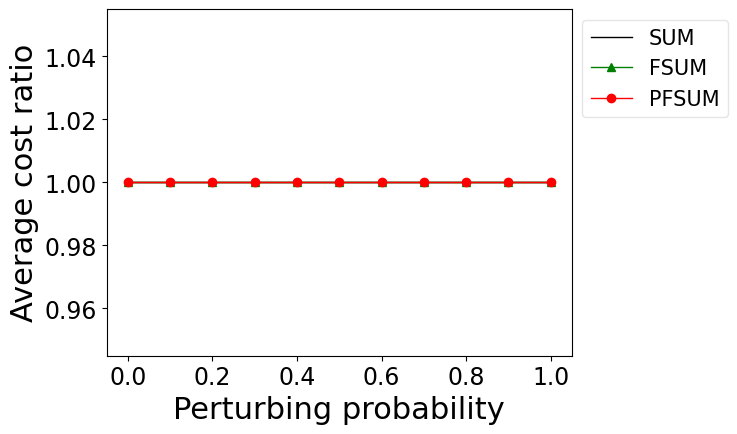

best SUM:  2
best FSUM:  1
best SUM$_w$:  1
best PFSUM:  2
best PDLA($\lambda$=1):  1
best PDLA($\lambda$=0.5):  1
best PDLA($\lambda$=0.2):  1
best SRL($\lambda$=1):  2
best SRL($\lambda$=0.5):  2
best SRL($\lambda$=0.2):  2
SUM [1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002]
FSUM [1.0029, 1.0029, 1.0029, 1.0029, 1.0029, 1.0029, 1.0029, 1.0029, 1.0029, 1.0029, 1.0029]
SUM$_w$ [1.0003, 1.0043, 1.024, 1.0076, 1.0154, 1.0401, 1.0258, 1.0434, 1.0437, 1.0706, 1.0525]
PFSUM [1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002]
PDLA($\lambda$=1) [1.007, 1.007, 1.007, 1.007, 1.007, 1.007, 1.007, 1.007, 1.007, 1.007, 1.007]
PDLA($\lambda$=0.5) [1.0069, 1.0069, 1.0151, 1.0155, 1.0333, 1.0326, 1.0373, 1.0418, 1.0465, 1.0557, 1.051]
PDLA($\lambda$=0.2) [1.0069, 1.0069, 1.0232, 1.0136, 1.048, 1.0589, 1.0548, 1.0882, 1.0807, 1.1266, 1.1232]
SRL($\lambda$=1) [1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.0002, 1.

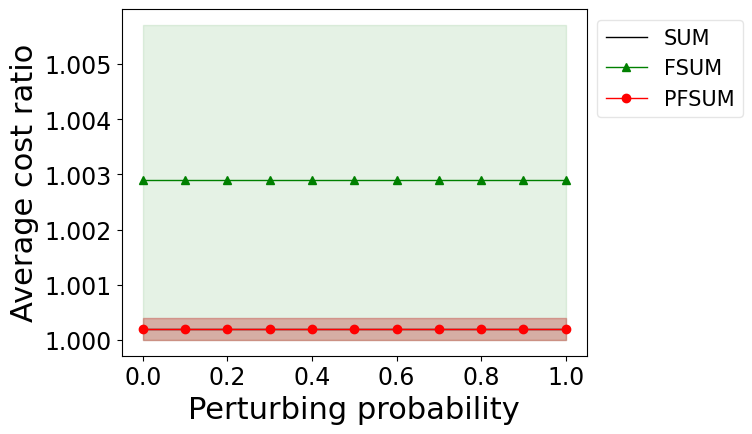

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  2
SUM [1.2059, 1.2059, 1.2059, 1.2059, 1.2059, 1.2059, 1.2059, 1.2059, 1.2059, 1.2059, 1.2059]
FSUM [1.1186, 1.1186, 1.1195, 1.1195, 1.1195, 1.1195, 1.1195, 1.1195, 1.1195, 1.1195, 1.1195]
SUM$_w$ [1.053, 1.0435, 1.0415, 1.0323, 1.0267, 1.0272, 1.025, 1.0251, 1.0239, 1.0238, 1.0238]
PFSUM [1.0257, 1.0257, 1.0262, 1.0263, 1.0263, 1.0263, 1.0263, 1.0263, 1.0273, 1.0263, 1.0263]
PDLA($\lambda$=1) [1.5311, 1.5311, 1.5311, 1.5311, 1.5311, 1.5311, 1.5311, 1.5311, 1.5311, 1.5311, 1.5311]
PDLA($\lambda$=0.5) [1.3698, 1.3707, 1.3717, 1.3733, 1.3705, 1.3728, 1.3725, 1.3796, 1.3771, 1.3757, 1.3759]
PDLA($\lambda$=0.2) [1.2001, 1.207, 1.211, 1.2116, 1.217, 1.2109, 1.2173, 1.2148, 1.2163, 1.2159, 1.2165]
SRL($\lambda$=1) [1.0273, 1.0273, 1.0273, 1.0273, 1.0273, 1.0273, 1.0273, 1

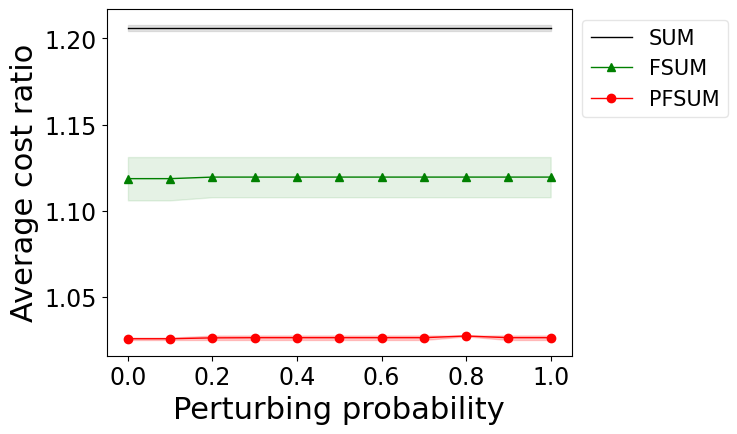

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  2
SUM [1.2054, 1.2054, 1.2054, 1.2054, 1.2054, 1.2054, 1.2054, 1.2054, 1.2054, 1.2054, 1.2054]
FSUM [1.0942, 1.0942, 1.0942, 1.0942, 1.0942, 1.0942, 1.0942, 1.0942, 1.0942, 1.0942, 1.0942]
SUM$_w$ [1.0409, 1.0301, 1.0293, 1.0238, 1.0167, 1.0161, 1.0142, 1.0148, 1.0134, 1.0128, 1.0128]
PFSUM [1.0156, 1.0156, 1.0156, 1.0156, 1.0156, 1.0156, 1.0156, 1.0156, 1.0156, 1.0156, 1.0156]
PDLA($\lambda$=1) [1.5325, 1.5325, 1.5325, 1.5325, 1.5325, 1.5325, 1.5325, 1.5325, 1.5325, 1.5325, 1.5325]
PDLA($\lambda$=0.5) [1.3624, 1.3632, 1.3621, 1.3619, 1.362, 1.3584, 1.3599, 1.3611, 1.359, 1.3598, 1.3598]
PDLA($\lambda$=0.2) [1.1992, 1.2007, 1.2013, 1.1998, 1.2028, 1.2013, 1.2021, 1.2005, 1.2004, 1.2008, 1.1993]
SRL($\lambda$=1) [1.0156, 1.0156, 1.0156, 1.0156, 1.0156, 1.0156, 1.0156

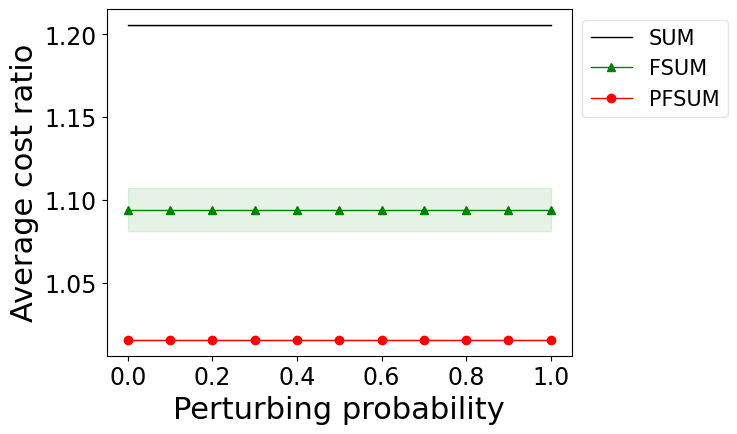

best SUM:  0
best FSUM:  0
best SUM$_w$:  1
best PFSUM:  1
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.1436, 1.1436, 1.1436, 1.1436, 1.1436, 1.1436, 1.1436, 1.1436, 1.1436, 1.1436, 1.1436]
FSUM [1.1859, 1.1897, 1.1935, 1.1965, 1.1953, 1.1966, 1.1982, 1.198, 1.198, 1.198, 1.198]
SUM$_w$ [1.0751, 1.0799, 1.0792, 1.0828, 1.0779, 1.0883, 1.0894, 1.0855, 1.0864, 1.0911, 1.0918]
PFSUM [1.0753, 1.0819, 1.0887, 1.0876, 1.0894, 1.0898, 1.0917, 1.0917, 1.0915, 1.092, 1.092]
PDLA($\lambda$=1) [1.662, 1.662, 1.662, 1.662, 1.662, 1.662, 1.662, 1.662, 1.662, 1.662, 1.662]
PDLA($\lambda$=0.5) [1.4572, 1.4673, 1.4823, 1.4932, 1.4839, 1.4932, 1.4839, 1.5058, 1.4985, 1.4902, 1.4948]
PDLA($\lambda$=0.2) [1.2861, 1.288, 1.3087, 1.3239, 1.3297, 1.3291, 1.3478, 1.3378, 1.3429, 1.3427, 1.3379]
SRL($\lambda$=1) [1.0927, 1.0927, 1.0927, 1.0927, 1.0927, 1.0927, 1.0927, 1.0927, 1.0927

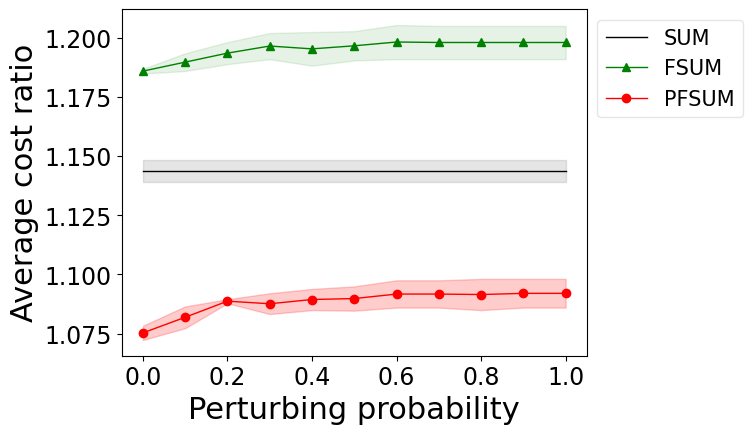

In [4]:
profile = "Commuters"
for param in parameter_sets:
    for price_dist in price_dists:
        plot_cr(param[0], param[1], param[2], price_dist, profile)

In [5]:
#clear results
result_crs = []

#for the occasional travelers, travel requests occur at intervals
parameter_sets = [(0.8, 10, 100), (0.6, 5, 100), (0.6, 10, 200), (0.6, 10, 2000), (0.2, 10, 400)]

for price_dist in price_dists:
    for exp_count in range(0, experiment_num):
        #generate an instance
        #np.random.seed(int(datetime.datetime.now().timestamp()))
        np.random.seed(exp_count)
        instance = ins.instance_generator(time_length, "Exponential", interval_mean, price_dist, price_mean)
        for perturb_prob in perturb_probabilitys:
            noisy_instance = ins.noisy_instance_generator(instance, price_dist, 2 * price_mean, perturb_prob)
            evaluate(instance, noisy_instance, parameter_sets, price_dist, perturb_prob)


bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by fsum'''
bought by 

best SUM:  0
best FSUM:  0
best SUM$_w$:  1
best PFSUM:  1
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0393, 1.0393, 1.0393, 1.0393, 1.0393, 1.0393, 1.0393, 1.0393, 1.0393, 1.0393, 1.0393]
FSUM [1.043, 1.0448, 1.0455, 1.0465, 1.0471, 1.0466, 1.0471, 1.0471, 1.0471, 1.0471, 1.0471]
SUM$_w$ [1.0241, 1.0322, 1.0423, 1.055, 1.0606, 1.0685, 1.0678, 1.0732, 1.0761, 1.0782, 1.0784]
PFSUM [1.0237, 1.0334, 1.0402, 1.0431, 1.0448, 1.0448, 1.0457, 1.0471, 1.0465, 1.0471, 1.0471]
PDLA($\lambda$=1) [1.0854, 1.0854, 1.0854, 1.0854, 1.0854, 1.0854, 1.0854, 1.0854, 1.0854, 1.0854, 1.0854]
PDLA($\lambda$=0.5) [1.0652, 1.0816, 1.0905, 1.095, 1.0969, 1.0973, 1.0951, 1.0959, 1.0961, 1.098, 1.0974]
PDLA($\lambda$=0.2) [1.0342, 1.0547, 1.0729, 1.0834, 1.0832, 1.0836, 1.0818, 1.0835, 1.0844, 1.085, 1.0848]
SRL($\lambda$=1) [1.0471, 1.0471, 1.0471, 1.0471, 1.0471, 1.0471, 1.0471, 1

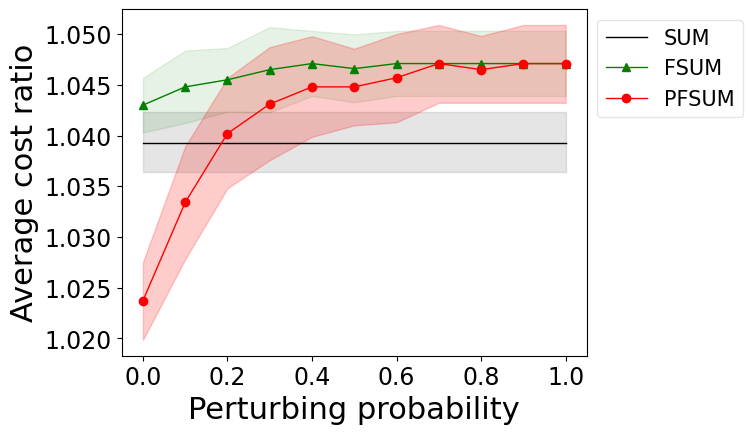

best SUM:  0
best FSUM:  0
best SUM$_w$:  2
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0373, 1.0373, 1.0373, 1.0373, 1.0373, 1.0373, 1.0373, 1.0373, 1.0373, 1.0373, 1.0373]
FSUM [1.0411, 1.0423, 1.0435, 1.0438, 1.0445, 1.0445, 1.0445, 1.0445, 1.0445, 1.0445, 1.0445]
SUM$_w$ [1.0209, 1.0327, 1.0408, 1.0491, 1.0536, 1.0576, 1.0604, 1.0633, 1.0658, 1.0676, 1.068]
PFSUM [1.0232, 1.0332, 1.0387, 1.0403, 1.0414, 1.0418, 1.0417, 1.0418, 1.0418, 1.0418, 1.0418]
PDLA($\lambda$=1) [1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 1.0935]
PDLA($\lambda$=0.5) [1.0688, 1.089, 1.0965, 1.0952, 1.0982, 1.0992, 1.0993, 1.1012, 1.1021, 1.1025, 1.1021]
PDLA($\lambda$=0.2) [1.0347, 1.0566, 1.0723, 1.0754, 1.0758, 1.0778, 1.076, 1.0767, 1.0768, 1.077, 1.077]
SRL($\lambda$=1) [1.0421, 1.0421, 1.0421, 1.0421, 1.0421, 1.0421, 1.0421, 1

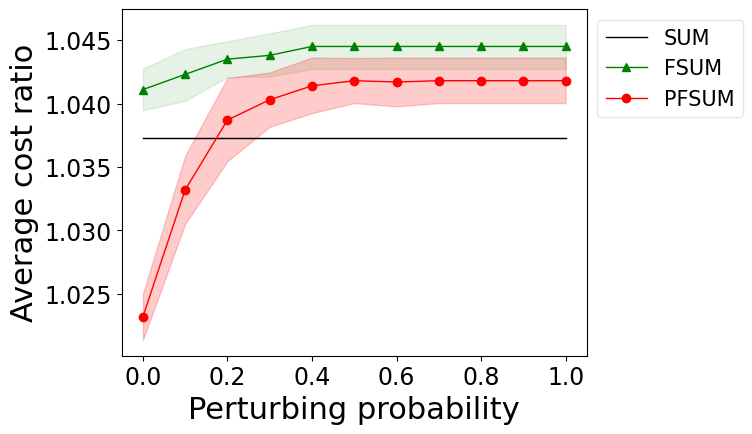

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  2
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0276, 1.0276, 1.0276, 1.0276, 1.0276, 1.0276, 1.0276, 1.0276, 1.0276, 1.0276, 1.0276]
FSUM [1.0297, 1.0308, 1.0331, 1.0321, 1.0329, 1.0341, 1.034, 1.0343, 1.0343, 1.0343, 1.0343]
SUM$_w$ [1.0179, 1.0274, 1.0454, 1.0569, 1.0675, 1.0762, 1.0814, 1.0882, 1.0952, 1.0987, 1.1005]
PFSUM [1.0163, 1.0182, 1.0231, 1.0281, 1.0314, 1.0295, 1.0331, 1.0335, 1.0338, 1.0348, 1.0344]
PDLA($\lambda$=1) [1.1074, 1.1074, 1.1074, 1.1074, 1.1074, 1.1074, 1.1074, 1.1074, 1.1074, 1.1074, 1.1074]
PDLA($\lambda$=0.5) [1.0905, 1.097, 1.1047, 1.1081, 1.1108, 1.1136, 1.1145, 1.1122, 1.1131, 1.1154, 1.1126]
PDLA($\lambda$=0.2) [1.0531, 1.0711, 1.0951, 1.101, 1.1172, 1.1191, 1.1158, 1.1179, 1.1188, 1.1178, 1.1181]
SRL($\lambda$=1) [1.0348, 1.0348, 1.0348, 1.0348, 1.0348, 1.0348, 1.0348,

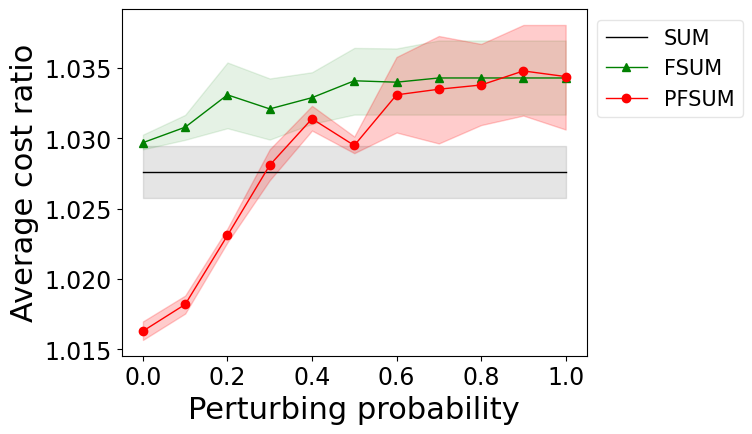

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  2
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0841, 1.0841, 1.0841, 1.0841, 1.0841, 1.0841, 1.0841, 1.0841, 1.0841, 1.0841, 1.0841]
FSUM [1.1056, 1.1092, 1.1105, 1.1122, 1.1112, 1.1136, 1.1141, 1.1145, 1.1148, 1.1148, 1.1148]
SUM$_w$ [1.0602, 1.0887, 1.108, 1.124, 1.1293, 1.1483, 1.1383, 1.1487, 1.1551, 1.1637, 1.1631]
PFSUM [1.0537, 1.0671, 1.0797, 1.0839, 1.0855, 1.0911, 1.0942, 1.0945, 1.0941, 1.0958, 1.0952]
PDLA($\lambda$=1) [1.1844, 1.1844, 1.1844, 1.1844, 1.1844, 1.1844, 1.1844, 1.1844, 1.1844, 1.1844, 1.1844]
PDLA($\lambda$=0.5) [1.1628, 1.1754, 1.1801, 1.1843, 1.1882, 1.184, 1.1835, 1.1856, 1.1868, 1.1877, 1.1867]
PDLA($\lambda$=0.2) [1.1163, 1.1428, 1.1633, 1.1705, 1.176, 1.181, 1.1792, 1.1805, 1.1813, 1.1834, 1.1836]
SRL($\lambda$=1) [1.0958, 1.0958, 1.0958, 1.0958, 1.0958, 1.0958, 1.0958, 1

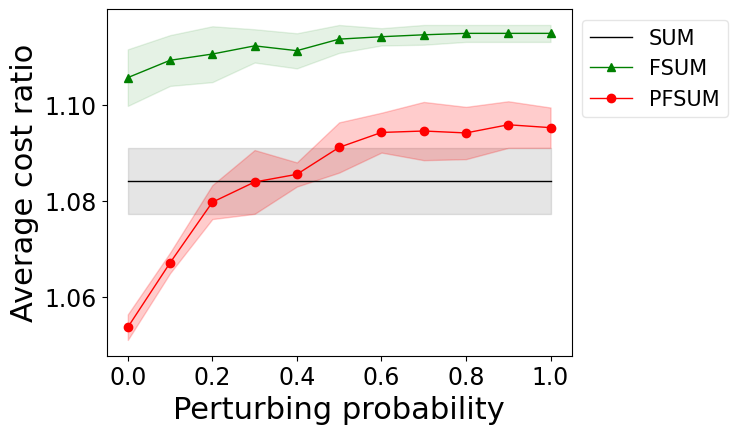

best SUM:  0
best FSUM:  0
best SUM$_w$:  1
best PFSUM:  1
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0915, 1.0915, 1.0915, 1.0915, 1.0915, 1.0915, 1.0915, 1.0915, 1.0915, 1.0915, 1.0915]
FSUM [1.1075, 1.1083, 1.1109, 1.1121, 1.1118, 1.1127, 1.1123, 1.1119, 1.1127, 1.1127, 1.1127]
SUM$_w$ [1.0512, 1.077, 1.0982, 1.1132, 1.1105, 1.1252, 1.1194, 1.1321, 1.1321, 1.1359, 1.1362]
PFSUM [1.0523, 1.0667, 1.0774, 1.0842, 1.0886, 1.0888, 1.0897, 1.0906, 1.0934, 1.0935, 1.0935]
PDLA($\lambda$=1) [1.1811, 1.1811, 1.1811, 1.1811, 1.1811, 1.1811, 1.1811, 1.1811, 1.1811, 1.1811, 1.1811]
PDLA($\lambda$=0.5) [1.1695, 1.178, 1.1779, 1.1837, 1.1853, 1.1835, 1.1823, 1.1846, 1.1838, 1.1852, 1.1848]
PDLA($\lambda$=0.2) [1.1129, 1.1421, 1.161, 1.1646, 1.1721, 1.1738, 1.174, 1.1748, 1.1754, 1.1752, 1.1752]
SRL($\lambda$=1) [1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 1.0935, 

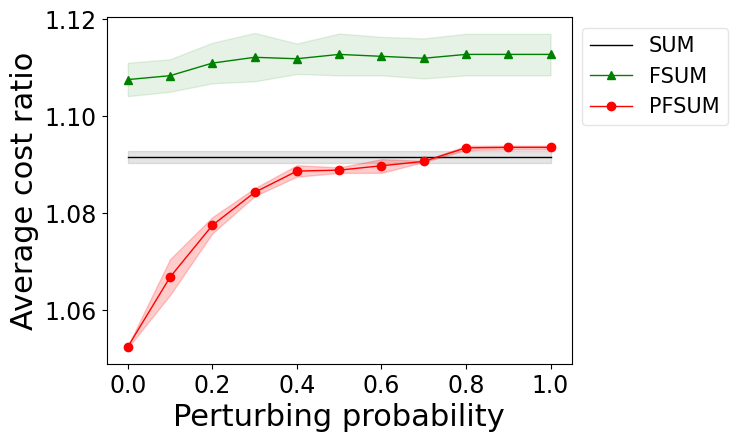

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  2
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0453, 1.0453, 1.0453, 1.0453, 1.0453, 1.0453, 1.0453, 1.0453, 1.0453, 1.0453, 1.0453]
FSUM [1.0587, 1.0606, 1.0616, 1.0619, 1.0622, 1.0621, 1.0643, 1.0651, 1.0661, 1.0658, 1.0665]
SUM$_w$ [1.0343, 1.0594, 1.0816, 1.1079, 1.1137, 1.1358, 1.1432, 1.1493, 1.1709, 1.187, 1.1814]
PFSUM [1.0304, 1.0368, 1.0406, 1.046, 1.0464, 1.0517, 1.0506, 1.0541, 1.0597, 1.0608, 1.0599]
PDLA($\lambda$=1) [1.2344, 1.2344, 1.2344, 1.2344, 1.2344, 1.2344, 1.2344, 1.2344, 1.2344, 1.2344, 1.2344]
PDLA($\lambda$=0.5) [1.233, 1.2405, 1.2489, 1.2467, 1.2492, 1.2524, 1.252, 1.2514, 1.2526, 1.2529, 1.2545]
PDLA($\lambda$=0.2) [1.1674, 1.1911, 1.2181, 1.2454, 1.2537, 1.2641, 1.2586, 1.2611, 1.2713, 1.267, 1.272]
SRL($\lambda$=1) [1.0622, 1.0622, 1.0622, 1.0622, 1.0622, 1.0622, 1.0622, 1.

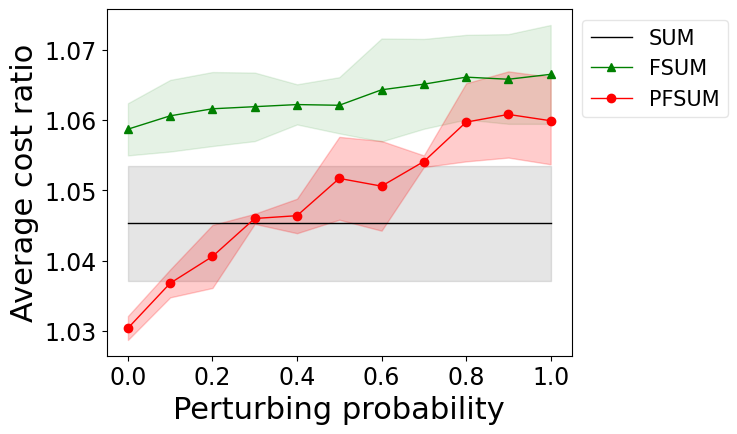

best SUM:  0
best FSUM:  0
best SUM$_w$:  1
best PFSUM:  1
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0836, 1.0836, 1.0836, 1.0836, 1.0836, 1.0836, 1.0836, 1.0836, 1.0836, 1.0836, 1.0836]
FSUM [1.0918, 1.095, 1.096, 1.0979, 1.0975, 1.0972, 1.0975, 1.0975, 1.0975, 1.0975, 1.0975]
SUM$_w$ [1.0505, 1.0677, 1.0895, 1.1162, 1.1267, 1.144, 1.1427, 1.1548, 1.1604, 1.1643, 1.1648]
PFSUM [1.0494, 1.0701, 1.0835, 1.0903, 1.0934, 1.0937, 1.0955, 1.0985, 1.0973, 1.0985, 1.0985]
PDLA($\lambda$=1) [1.1794, 1.1794, 1.1794, 1.1794, 1.1794, 1.1794, 1.1794, 1.1794, 1.1794, 1.1794, 1.1794]
PDLA($\lambda$=0.5) [1.1371, 1.1716, 1.1902, 1.1997, 1.2036, 1.2045, 1.1998, 1.2015, 1.202, 1.206, 1.2047]
PDLA($\lambda$=0.2) [1.0719, 1.1149, 1.1533, 1.1753, 1.1748, 1.1757, 1.1718, 1.1754, 1.1772, 1.1785, 1.1781]
SRL($\lambda$=1) [1.0985, 1.0985, 1.0985, 1.0985, 1.0985, 1.0985, 1.0985, 1

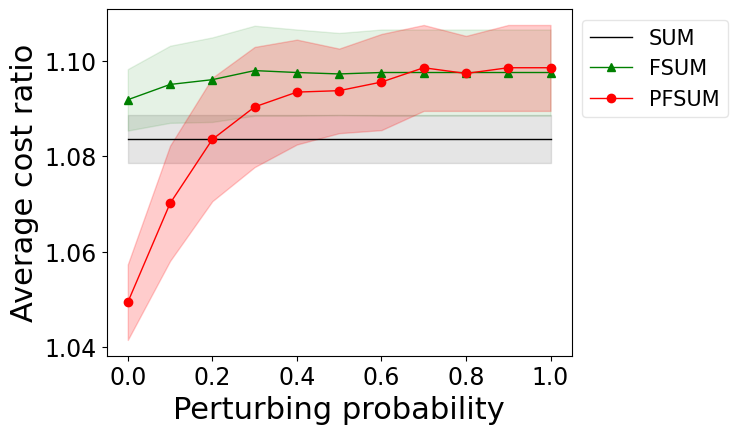

best SUM:  0
best FSUM:  0
best SUM$_w$:  2
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.0777, 1.0777, 1.0777, 1.0777, 1.0777, 1.0777, 1.0777, 1.0777, 1.0777, 1.0777, 1.0777]
FSUM [1.088, 1.0894, 1.0911, 1.0916, 1.0934, 1.0934, 1.0934, 1.0934, 1.0934, 1.0934, 1.0934]
SUM$_w$ [1.0454, 1.0698, 1.086, 1.1041, 1.1124, 1.1207, 1.1266, 1.1327, 1.138, 1.1416, 1.1426]
PFSUM [1.0484, 1.0694, 1.0806, 1.0844, 1.0863, 1.0871, 1.0868, 1.0871, 1.0871, 1.0871, 1.0871]
PDLA($\lambda$=1) [1.196, 1.196, 1.196, 1.196, 1.196, 1.196, 1.196, 1.196, 1.196, 1.196, 1.196]
PDLA($\lambda$=0.5) [1.1442, 1.1867, 1.2023, 1.1995, 1.2059, 1.2079, 1.2082, 1.2122, 1.2141, 1.2148, 1.2141]
PDLA($\lambda$=0.2) [1.0728, 1.1187, 1.1515, 1.1581, 1.1588, 1.163, 1.1594, 1.1608, 1.161, 1.1615, 1.1615]
SRL($\lambda$=1) [1.0877, 1.0877, 1.0877, 1.0877, 1.0877, 1.0877, 1.0877, 1.0877, 1.08

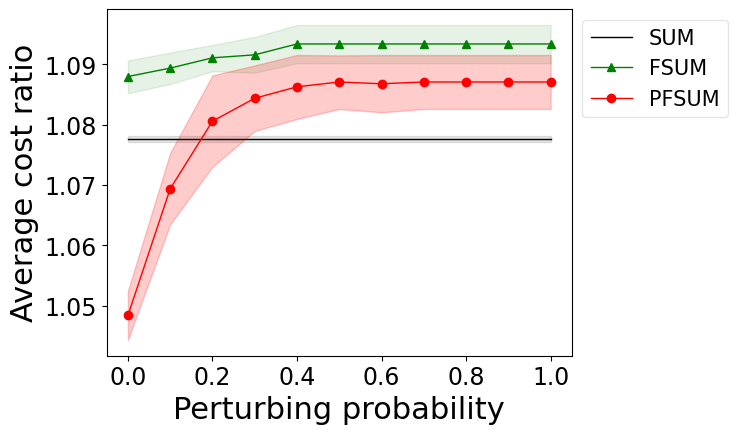

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  2
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.06, 1.06, 1.06, 1.06, 1.06, 1.06, 1.06, 1.06, 1.06, 1.06, 1.06]
FSUM [1.0647, 1.0663, 1.0709, 1.0691, 1.0712, 1.0734, 1.074, 1.074, 1.074, 1.074, 1.074]
SUM$_w$ [1.0392, 1.0598, 1.099, 1.124, 1.1473, 1.1651, 1.1777, 1.1925, 1.2081, 1.2152, 1.2191]
PFSUM [1.0356, 1.0397, 1.0501, 1.0625, 1.0702, 1.066, 1.0738, 1.0745, 1.0753, 1.0775, 1.0765]
PDLA($\lambda$=1) [1.2346, 1.2346, 1.2346, 1.2346, 1.2346, 1.2346, 1.2346, 1.2346, 1.2346, 1.2346, 1.2346]
PDLA($\lambda$=0.5) [1.1976, 1.2118, 1.2286, 1.2359, 1.2417, 1.2478, 1.2497, 1.2449, 1.2467, 1.2517, 1.2455]
PDLA($\lambda$=0.2) [1.116, 1.1551, 1.2072, 1.2205, 1.2555, 1.2596, 1.2525, 1.257, 1.259, 1.2569, 1.2576]
SRL($\lambda$=1) [1.0775, 1.0775, 1.0775, 1.0775, 1.0775, 1.0775, 1.0775, 1.0775, 1.0775, 1.0775, 1.077

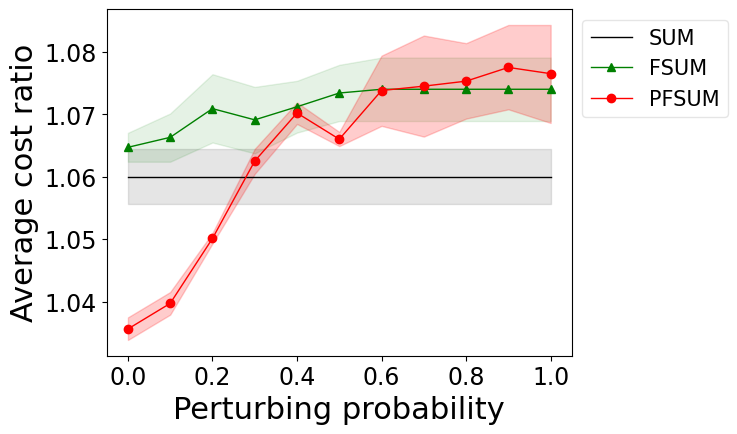

best SUM:  2
best FSUM:  2
best SUM$_w$:  2
best PFSUM:  2
best PDLA($\lambda$=1):  2
best PDLA($\lambda$=0.5):  2
best PDLA($\lambda$=0.2):  2
best SRL($\lambda$=1):  2
best SRL($\lambda$=0.5):  2
best SRL($\lambda$=0.2):  2
SUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
FSUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SUM$_w$ [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PFSUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=1) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=0.5) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=0.2) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=1) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=0.5) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=0.2) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Occasional Traverlers, Beta = 0.6, T = 10, C = 2000, Price distribution = Unif

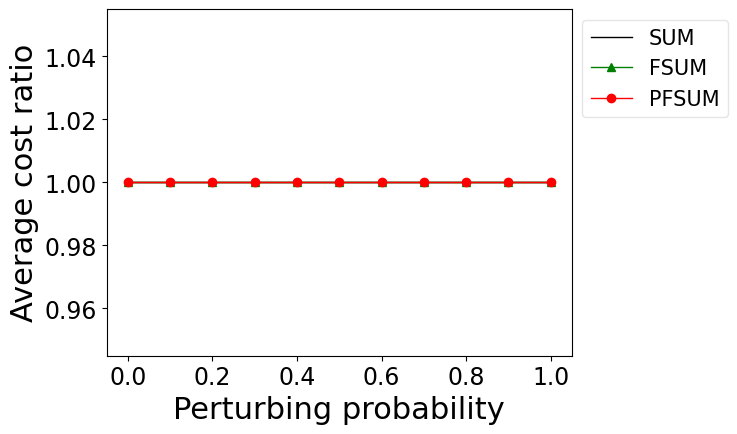

best SUM:  2
best FSUM:  2
best SUM$_w$:  2
best PFSUM:  2
best PDLA($\lambda$=1):  2
best PDLA($\lambda$=0.5):  2
best PDLA($\lambda$=0.2):  2
best SRL($\lambda$=1):  2
best SRL($\lambda$=0.5):  2
best SRL($\lambda$=0.2):  2
SUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
FSUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SUM$_w$ [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PFSUM [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=1) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=0.5) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
PDLA($\lambda$=0.2) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=1) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=0.5) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
SRL($\lambda$=0.2) [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Occasional Traverlers, Beta = 0.6, T = 10, C = 2000, Price distribution = Norm

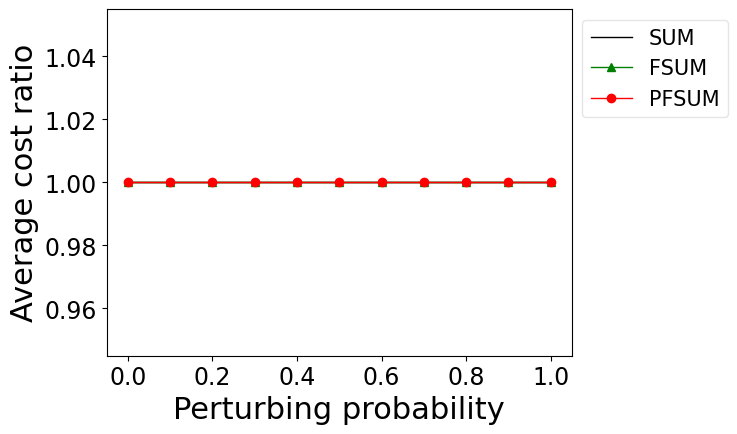

best SUM:  1
best FSUM:  1
best SUM$_w$:  2
best PFSUM:  1
best PDLA($\lambda$=1):  1
best PDLA($\lambda$=0.5):  1
best PDLA($\lambda$=0.2):  1
best SRL($\lambda$=1):  1
best SRL($\lambda$=0.5):  1
best SRL($\lambda$=0.2):  1
SUM [1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003]
FSUM [1.0063, 1.0063, 1.0063, 1.0063, 1.0063, 1.0063, 1.0063, 1.0063, 1.0063, 1.0063, 1.0063]
SUM$_w$ [1.0002, 1.0002, 1.0432, 1.0167, 1.02, 1.0558, 1.0512, 1.0812, 1.0856, 1.1305, 1.1425]
PFSUM [1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003]
PDLA($\lambda$=1) [1.0162, 1.0162, 1.0162, 1.0162, 1.0162, 1.0162, 1.0162, 1.0162, 1.0162, 1.0162, 1.0162]
PDLA($\lambda$=0.5) [1.0155, 1.0155, 1.0155, 1.0155, 1.0155, 1.0155, 1.0155, 1.0155, 1.0155, 1.0155, 1.0155]
PDLA($\lambda$=0.2) [1.0155, 1.0155, 1.0273, 1.0382, 1.0279, 1.0375, 1.0155, 1.0382, 1.0811, 1.0836, 1.0879]
SRL($\lambda$=1) [1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003, 1.0003

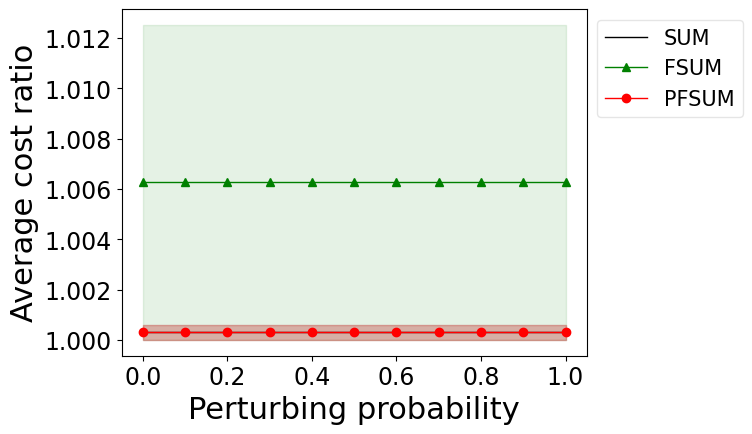

best SUM:  0
best FSUM:  0
best SUM$_w$:  1
best PFSUM:  1
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.1861, 1.1861, 1.1861, 1.1861, 1.1861, 1.1861, 1.1861, 1.1861, 1.1861, 1.1861, 1.1861]
FSUM [1.2138, 1.2158, 1.217, 1.2203, 1.2196, 1.2184, 1.2176, 1.2196, 1.2196, 1.2196, 1.2196]
SUM$_w$ [1.1123, 1.1508, 1.1993, 1.2586, 1.2823, 1.3206, 1.3177, 1.3445, 1.3569, 1.3657, 1.3668]
PFSUM [1.1102, 1.1563, 1.1861, 1.2012, 1.2082, 1.2087, 1.2128, 1.2194, 1.2168, 1.2194, 1.2194]
PDLA($\lambda$=1) [1.3996, 1.3996, 1.3996, 1.3996, 1.3996, 1.3996, 1.3996, 1.3996, 1.3996, 1.3996, 1.3996]
PDLA($\lambda$=0.5) [1.3053, 1.3819, 1.4235, 1.4443, 1.4532, 1.4552, 1.4448, 1.4485, 1.4495, 1.4584, 1.4556]
PDLA($\lambda$=0.2) [1.1601, 1.2559, 1.3411, 1.3891, 1.3889, 1.3909, 1.382, 1.3902, 1.3942, 1.397, 1.3962]
SRL($\lambda$=1) [1.2194, 1.2194, 1.2194, 1.2194, 1.2194, 1.2194, 1.2194,

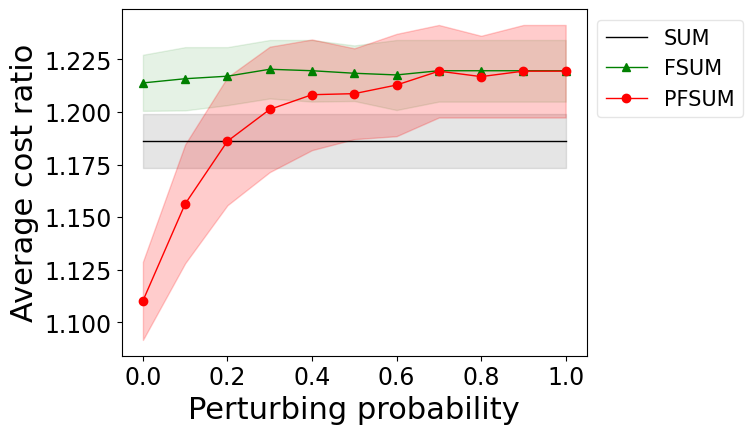

best SUM:  0
best FSUM:  0
best SUM$_w$:  2
best PFSUM:  0
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.172, 1.172, 1.172, 1.172, 1.172, 1.172, 1.172, 1.172, 1.172, 1.172, 1.172]
FSUM [1.1998, 1.1989, 1.1991, 1.2004, 1.201, 1.201, 1.201, 1.201, 1.201, 1.201, 1.201]
SUM$_w$ [1.1006, 1.1545, 1.1904, 1.2304, 1.2488, 1.2671, 1.2801, 1.2936, 1.3053, 1.3135, 1.3155]
PFSUM [1.1072, 1.1537, 1.1785, 1.1869, 1.191, 1.1927, 1.1922, 1.1928, 1.1928, 1.1928, 1.1928]
PDLA($\lambda$=1) [1.4338, 1.4338, 1.4338, 1.4338, 1.4338, 1.4338, 1.4338, 1.4338, 1.4338, 1.4338, 1.4338]
PDLA($\lambda$=0.5) [1.3191, 1.4132, 1.4477, 1.4416, 1.4557, 1.4577, 1.4608, 1.4696, 1.4737, 1.4753, 1.4737]
PDLA($\lambda$=0.2) [1.1611, 1.2628, 1.3351, 1.3499, 1.3515, 1.3606, 1.3526, 1.3558, 1.3563, 1.3573, 1.3573]
SRL($\lambda$=1) [1.1942, 1.1942, 1.1942, 1.1942, 1.1942, 1.1942, 1.1942, 1.1942, 1.1942,

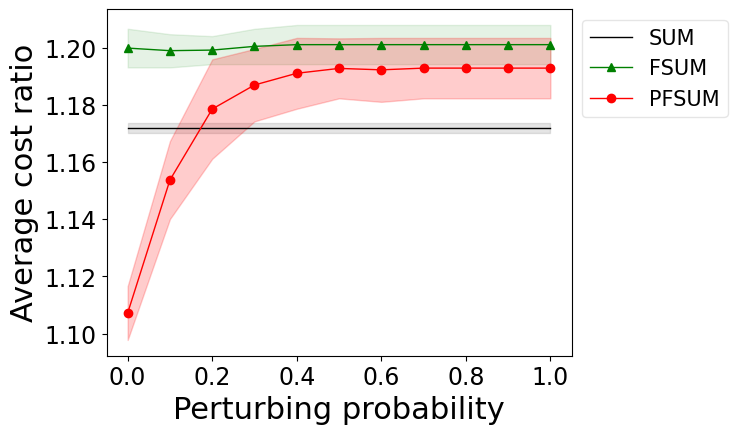

best SUM:  0
best FSUM:  0
best SUM$_w$:  0
best PFSUM:  2
best PDLA($\lambda$=1):  0
best PDLA($\lambda$=0.5):  0
best PDLA($\lambda$=0.2):  0
best SRL($\lambda$=1):  0
best SRL($\lambda$=0.5):  0
best SRL($\lambda$=0.2):  0
SUM [1.1473, 1.1473, 1.1473, 1.1473, 1.1473, 1.1473, 1.1473, 1.1473, 1.1473, 1.1473, 1.1473]
FSUM [1.1861, 1.1888, 1.1941, 1.1943, 1.1917, 1.1945, 1.196, 1.196, 1.196, 1.196, 1.196]
SUM$_w$ [1.0962, 1.1463, 1.2421, 1.3024, 1.3597, 1.4034, 1.4333, 1.4704, 1.5079, 1.5251, 1.5348]
PFSUM [1.0874, 1.0973, 1.1226, 1.153, 1.1716, 1.1616, 1.1802, 1.1819, 1.184, 1.1894, 1.1866]
PDLA($\lambda$=1) [1.576, 1.576, 1.576, 1.576, 1.576, 1.576, 1.576, 1.576, 1.576, 1.576, 1.576]
PDLA($\lambda$=0.5) [1.4845, 1.5197, 1.56, 1.5774, 1.5912, 1.6057, 1.6096, 1.5994, 1.603, 1.615, 1.6]
PDLA($\lambda$=0.2) [1.2844, 1.3799, 1.5059, 1.54, 1.6237, 1.6339, 1.6167, 1.6273, 1.6326, 1.6276, 1.629]
SRL($\lambda$=1) [1.1894, 1.1894, 1.1894, 1.1894, 1.1894, 1.1894, 1.1894, 1.1894, 1.1894, 1.1894, 

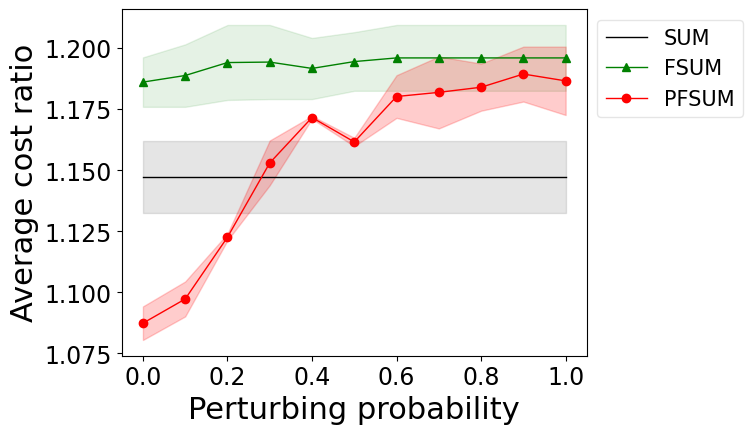

In [6]:
profile = "Occasional Traverlers"
for param in parameter_sets:
    for price_dist in price_dists:
        plot_cr(param[0], param[1], param[2], price_dist, profile)

###### 